In [1]:
system.time({source("paper_utils.R")})


Attaching package: ‘Rcpp’

The following object is masked from ‘package:inline’:

    registerPlugin


Attaching package: ‘singlecellmethods’

The following object is masked _by_ ‘.GlobalEnv’:

    normalizeData



   user  system elapsed 
 21.422   6.736  39.421 

# Load all cached results

In [255]:
cachedir <- "/data/srlab/ik936/NOTCH/data/cache/"
tissue <- readRDS(file.path(cachedir, "analysis_sc_tissue.rds"))
bulk <- readRDS('/data/srlab/ik936/NOTCH/data/cache/bulk_data.rds')

# Define color schemes and nice names

In [3]:
nice_name <- c(pericytes = "Pericytes", lining = "Lining Fibroblasts", sublining = "Sublining Fibroblasts", 
               sublining_cd34 = "Sublining Fibroblasts", endothelial = "Blood Vessel Cells", 
               oa = "Tissue OA", ra = "Tissue RA", MM1 = "fibroblast organoid", 
               MM2 = "fibroblast + blood vessel\norganoid", Tissue = "synovial tissue", 
              endo_st = "blood vessel cells", 
                peri_st = "pericytes", 
                endo_mm = "blood vessel cells",
                peri_mm = "fibroblasts + pericytes",
               primary = "Synovial Tissue", culture = "Organoid",
               blood = "Blood vessel cells", lymph = "Lymphatic vessel cells"
)
nice_names <- data.frame(nice_name, stringsAsFactors = FALSE) %>% tibble::rownames_to_column("given_name")
nice_names_list <- nice_name
nice_names

given_name,nice_name
pericytes,Pericytes
lining,Lining Fibroblasts
sublining,Sublining Fibroblasts
sublining_cd34,Sublining Fibroblasts
endothelial,Blood Vessel Cells
oa,Tissue OA
ra,Tissue RA
MM1,fibroblast organoid
MM2,fibroblast + blood vessel organoid
Tissue,synovial tissue


# Figure 1

In [4]:
plt1 <- list()

## UMAP: cell types + gradient

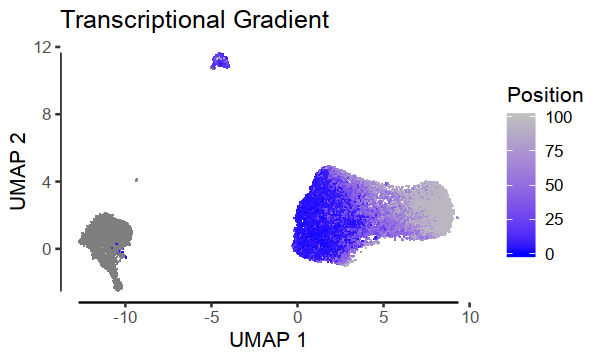

In [21]:
fig.size(3, 5)
(plt1$umap_main <- tissue$umap_harmony %>%
    cbind(tissue$meta_data) %>% 
    subset(cell_type != "leukocytes") %>% 
    dplyr::inner_join(nice_names, by = c("cell_type" = "given_name")) %>%
    ggplot(aes(`1`, `2`, color = 100 - time)) + 
        geom_point(shape = '.') + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        theme_tufte(base_size = 12, base_family = 'Helvetica') + geom_rangeframe(color = "black") + 
        labs(title = "Transcriptional Gradient", color = "Position", x = "UMAP 1", y = "UMAP 2") + 
        NULL
)


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/umap_main.pdf', plot = plt1$umap_main, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

## Marker UMAP

In [7]:
fig.size(2, 5)
features <- c('PRG4', 'THY1')
with(tissue, {
    idx_use <- 1:nrow(meta_data)
    plt_list <<- lapply(features, function(feature) {
        plotFeatures(exprs_norm[, idx_use], umap_harmony[idx_use, ], order_by_expression = FALSE, no_guide = FALSE,
                     feature, nrow = 1, qlo = .02, qhi = .8)        
    })

#     plt_list <<- plotFeatures(exprs_norm[, idx_use], umap_harmony[idx_use, ], order_by_expression = FALSE, no_guide = FALSE,
#                  features, nrow = 1, qlo = .02, qhi = .8)
})


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


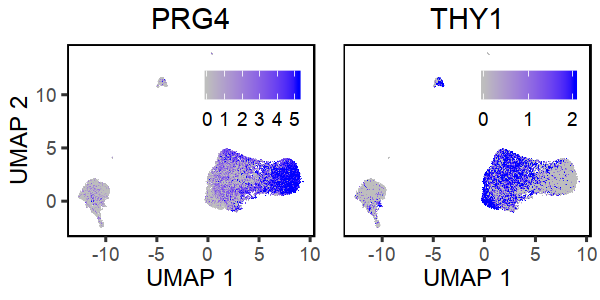

In [22]:
fig.size(2.5, 5)
(plt1$umap_markers <- plt_list[[1]] + 
    labs(color = '') + 
    theme(panel.background = element_rect(), plot.title = element_text(hjust = 0.5),
          legend.position="bottom", legend.box = "horizontal") + 
    scale_color_gradient2(
        mid = "grey", high = "blue", midpoint = 0, 
        guide = guide_colorbar(
            direction = "horizontal", title.position = "top",
            label.position = "bottom", label.hjust = 0.5, 
            label.vjust = 0.5, barwidth = 4,
        ), breaks = 0:5
    ) + 
    theme(legend.position = c(0.75, .8)) + 
plt_list[[2]] + 
#     labs(color = "Log CPM") + 
    labs(color = '') + 
    theme(panel.background = element_rect(), plot.title = element_text(hjust = 0.5),
          axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank(), 
          legend.position="bottom", legend.box = "horizontal") + 
    scale_color_gradient2(
        mid = "grey", high = "blue", midpoint = 0, 
        guide = guide_colorbar(
            direction = "horizontal", title.position = "top",
            label.position = "bottom", label.hjust = 0.5, 
            label.vjust = 0.5, barwidth = 4,
        ), breaks = 0:5
    ) + 
    theme(legend.position = c(0.75, .8)) + 
NULL)


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/umap_markers.pdf', plot = plt1$umap_markers, device = "pdf", 
       dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

## Expression vs pseudotime

In [9]:
bin_95 <- function (data_df, xvar, yvars, num.bin, .include.lowest = TRUE) 
{
    data_df <- data.frame(data_df)
    x <- data_df[[xvar]]
    .breaks <- unique(quantile(x, probs = seq(0, 1, length.out = num.bin)))
    bin_means <- 0.5 * (head(.breaks, -1) + tail(.breaks, -1))
    bins_freq <- cut(x, .breaks, include.lowest = .include.lowest)
    levels(bins_freq) <- bin_means
    xmeans <- lapply(split(x, as.integer(bins_freq)), mean) %>% 
        as.numeric
    res_df <- Reduce(rbind, lapply(yvars, function(yvar) {
        y <- data_df[[yvar]]
        ymeans <- lapply(split(y, as.integer(bins_freq)), mean) %>% 
            as.numeric
        ysd <- lapply(split(y, as.integer(bins_freq)), sd) %>% 
            as.numeric
        data.frame(xval = xmeans) %>% cbind(Reduce(rbind, lapply(split(y, 
            as.integer(bins_freq)), function(.x) quantile(.x, 
            c(0.05, 0.95)))) %>% data.frame() %>% dplyr::mutate(symbol = yvar)) %>% 
            cbind(yval = ymeans, ysd = ysd)
    })) %>% data.frame()
    return(res_df)
}                                   

In [318]:
bulk$dge_dll4 %>% subset(logFC > 0 & adj.P.Val < .05) %>% nrow
bulk$dge_jag1 %>% subset(logFC > 0 & adj.P.Val < .05) %>% nrow

[1] 111

[1] 45

In [314]:
data.table(tissue$meta_data)[cell_type == 'pericytes', .(mean(100 - time), sd(100 - time))]

V1,V2
20.60889,11.68554


In [323]:
markers <- c("PRG4", "THY1")
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c("lining", "sublining"))
    markers <- c("PRG4", "THY1")
    ldata <<- data.frame(time = meta_data[idx_use, "time"], t(as.matrix(exprs_norm[markers, idx_use]))) %>% 
    bin_95("time", markers, 1e2)
})


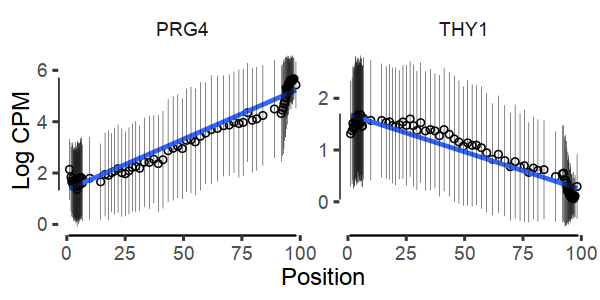

In [324]:
fig.size(2.5, 5)
(plt1$pseudotime_markers <- ldata %>% 
    ggplot(aes(100 - xval, yval)) + 
         geom_point(shape = 21) + 
#          geom_point(shape = ".") + 
        geom_smooth(method = "lm") + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd), size = .1) +
        facet_wrap(~symbol, scales = "free_y", nrow = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        labs(y = "Log CPM", x = "Position")
)    


ggsave('/data/srlab/ik936/NOTCH/paper/figure1/pseudotime_markers.pdf', plot = plt1$pseudotime_markers, device = "pdf", 
       dpi = 300, width = 5, height = 2.5, useDingbats = FALSE)

In [413]:
with(tissue, {
    idx_use <- which(meta_data$cell_type %in% c("lining", "sublining"))
    markers <- c("PRG4", "THY1")
    ldata <- data.frame(time = meta_data[idx_use, "time"], t(as.matrix(exprs_norm[markers, idx_use])))
    print(head(ldata))
    
    cor.test(~ time + PRG4, ldata, method = 'spearman') %>% broom::tidy() %>% print()
    cor.test(~ time + THY1, ldata, method = 'spearman') %>% broom::tidy() %>% print()
    
})

                            time     PRG4     THY1
AAACCTGAGACAAAGG_BWH075 24.55933 3.535234 0.000000
AAACCTGAGGTAGCCA_BWH075 97.77696 0.000000 2.363350
AAACCTGCAATCTGCA_BWH075 94.76058 2.676339 0.000000
AAACCTGCATTATCTC_BWH075 13.16606 3.726049 0.000000
AAACCTGGTAAACCTC_BWH075 52.32442 1.498020 0.000000
AAACCTGGTACCGCTG_BWH075 75.66847 3.285495 2.698028


Warning message in cor.test.default(x = c(24.5593295035345, 97.7769579428536, 94.7605829240305, :
“Cannot compute exact p-value with ties”

# A tibble: 1 x 5
  estimate statistic p.value method                          alternative
     <dbl>     <dbl>   <dbl> <chr>                           <chr>      
1   -0.670   5.61e12       0 Spearman's rank correlation rho two.sided  


Warning message in cor.test.default(x = c(24.5593295035345, 97.7769579428536, 94.7605829240305, :
“Cannot compute exact p-value with ties”

# A tibble: 1 x 5
  estimate statistic p.value method                          alternative
     <dbl>     <dbl>   <dbl> <chr>                           <chr>      
1    0.469   1.78e12       0 Spearman's rank correlation rho two.sided  


## Proportions

Joining, by = "donor"


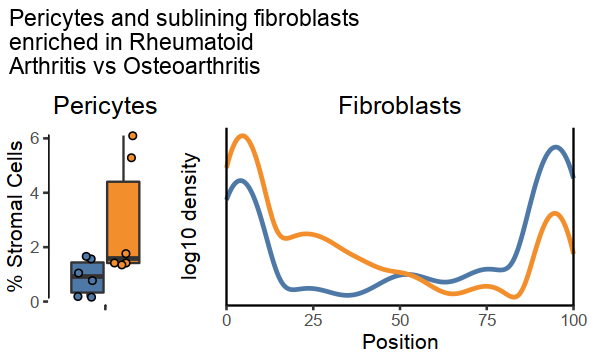

In [185]:
.x <- tissue$meta_data %>% 
    subset(cell_type != "leukocytes") %>% 
    with(table(cell_type, donor)) %>% prop.table(2)

fig.size(3, 5)
(plt1$proportions <- data.table(.x) %>% 
    dplyr::inner_join(unique(tissue$meta_data[, c("donor", "disease")])) %>% 
    dplyr::mutate(disease = ifelse(grepl("^OA", donor), "Osteoarthritis", "Rheumatoid Arthritis")) %>% 
    dplyr::mutate(cell_type = factor(cell_type, c("lining", "sublining", "pericytes", "endothelial"))) %>% 
    subset(cell_type == "pericytes") %>% 
    ggplot(aes(cell_type, 100 * N, fill = disease)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitterdodge(.75, jitter.height = 0, jitter.width = .2)) + 
        theme_tufte(base_size = 12, base_family = 'Helvetica') + 
        geom_rangeframe() + 
        guides(fill = FALSE) + 
        scale_fill_tableau() +
        theme(
            axis.text.x = element_blank(),
#             axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5), 
            strip.text = element_blank(), 
            plot.title = element_text(hjust = .5)
        ) + 
        scale_x_discrete(labels = nice_names_list) + 
        labs(y = "% Stromal Cells", x = "", title = "Pericytes") + 
tissue$meta_data %>% 
    subset(cell_type %in% c("lining", "sublining")) %>% 
#     dplyr::mutate(time_section = cut(100 - time, c(0, 15, 85, 100), include.lowest = TRUE)) %>% 
    ggplot(aes(100 - time)) + 
        geom_line(stat="density", aes(color = disease), size = 1) + scale_color_tableau() +  
    geom_vline(xintercept = c(0, 100)) + 
#         geom_density(aes(color = disease), size = 1) + scale_color_tableau() + 
#         geom_density(aes(fill = disease), alpha = .4) + scale_fill_tableau() +   
    theme_tufte(base_size = 12, base_family = 'Helvetica') +
    geom_rangeframe(color = "black") + 
    guides(color = FALSE, fill = FALSE) + 
    labs(color = "Position", x = "Position", y = "log10 density", title = 'Fibroblasts') + 
    theme(axis.ticks.y = element_blank(), 
          axis.text.y = element_blank(), 
         plot.title = element_text(hjust = .5)) + 
#           panel.background = element_rect()) + 
#     scale_x_continuous(breaks = seq(0, 100, 5)) + 
#     scale_x_continuous(breaks = c(0, 15, 85, 100)) + 
    scale_y_log10() + 
    plot_layout(widths = c(.3, 1)) + 
    plot_annotation(
        title = 'Pericytes and sublining fibroblasts\nenriched in Rheumatoid\nArthritis vs Osteoarthritis'
    ) + 
#     facet_wrap(~time_section, nrow = 1, scales = "free") + 
    NULL

)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/proportions.pdf', plot = plt1$proportions, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

In [190]:
data_df <- data.table(.x) %>% 
    dplyr::inner_join(unique(tissue$meta_data[, c("donor", "disease")])) %>% 
    dplyr::mutate(disease = ifelse(grepl("^OA", donor), "Osteoarthritis", "Rheumatoid Arthritis")) %>% 
    dplyr::mutate(cell_type = factor(cell_type, c("lining", "sublining", "pericytes", "endothelial"))) %>% 
    subset(cell_type == "pericytes") 


wilcox.test(N ~ disease, data_df)

Joining, by = "donor"



	Wilcoxon rank sum test

data:  N by disease
W = 6, p-value = 0.06494
alternative hypothesis: true location shift is not equal to 0


## Pseudotime

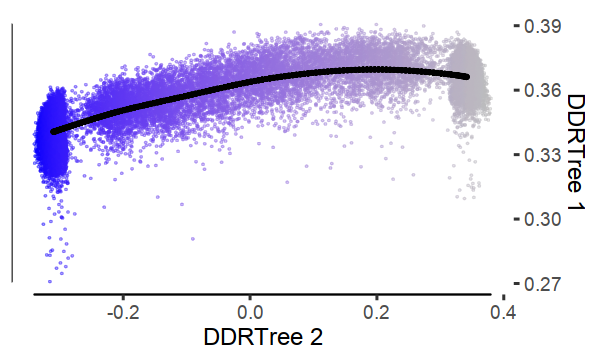

In [58]:
fig.size(3, 5)
(plt1$ddrtree <- data.frame(tissue$ddrtree_res$Z) %>% 
    cbind(tissue$meta_data %>% subset(cell_type %in% c("lining", "sublining"))) %>%
    ggplot(aes(-X2, X1)) + 
        geom_point_rast(dpi = 300, width = 5, height = 3, size = .5, aes(color = 100 - time), alpha = .4) + 
        geom_point_rast(dpi = 300, width = 5, height = 3, data = data.frame(t(tissue$ddrtree_res$Y))) + 
        theme_tufte(base_size = 14) + geom_rangeframe(color = "black") + 
        labs(x = "DDRTree 2", y = "DDRTree 1") + 
        scale_color_gradient2(mid = "blue", high = "grey", midpoint = 0) + 
        scale_y_continuous(position = "right") +   
         guides(color = FALSE) + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/ddrtree.pdf', plot = plt1$ddrtree, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

## Immunofluorescence 

In [14]:
data_if <- fread("/data/srlab/ik936/NOTCH/paper/if_distances.txt")
data_if_binned <- data_if %>% 
    subset(Sample == "RA195" & Image.number == 2) %>% 
    subset(!is.na(dist_EC2)) %>% 
    bin_95("dist_EC2", c("CD146", "ratio"), 100)

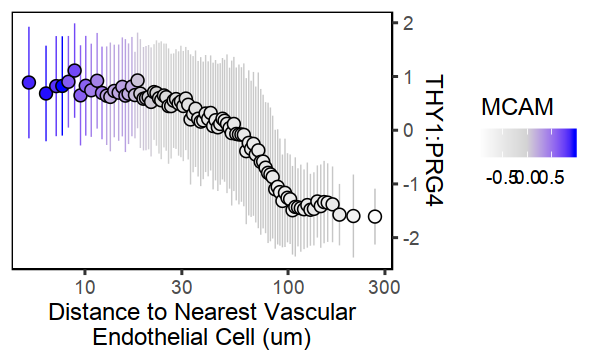

In [57]:
fig.size(3, 5)
(plt1$if_corr <- data_if_binned %>% 
    subset(symbol == "ratio") %>% 
    cbind(    
        MCAM = data_if_binned %>% subset(symbol == "CD146") %>% with(yval)    
    ) %>% 
    ggplot(aes(xval, yval)) + 
        geom_errorbar(width=0, aes(ymin=yval - ysd, ymax=yval + ysd, color = MCAM), size = .3) +
        geom_point(shape = 21, size = 3, aes(fill = MCAM)) + 
        scale_color_gradient2(low = "grey", high = "blue", mid = "lightgrey") + 
        scale_fill_gradient2(
            low = "white", high = "blue", mid = "lightgrey",
                    guide = guide_colorbar(
                        direction = "horizontal", title.position = "top",
                        label.position = "bottom", label.hjust = 0.5, 
                        label.vjust = 0.5, barwidth = 4,
                    )
        ) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        theme(panel.background = element_rect()) + 
        labs(y = "THY1:PRG4", x = "Distance to Nearest Vascular\nEndothelial Cell (um)") + 
        guides(color = FALSE) + 
        scale_y_continuous(position = "right") + 
        scale_x_log10() + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/if_corr.pdf', plot = plt1$if_corr, device = "pdf", 
       dpi = 300, width = 5, height = 3, useDingbats = FALSE)

## Inset

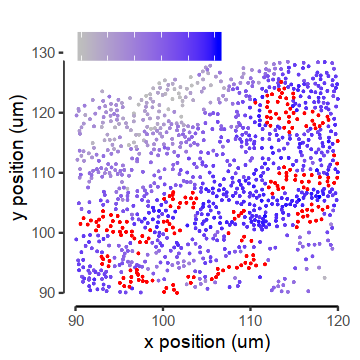

In [32]:
fig.size(3, 3)
(plt1$if_scatter <- data_if %>% 
    subset(Sample == 'RA195' & Image.number == 2) %>% 
    subset(center_x >= .9 & center_x <= 1.2 & center_y >= .9 & center_y <= 1.3) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point_rast(
            data = . %>% subset(is_ec != 1), aes(color = ratio), size = .5,
            dpi = 300, width = 3, height = 3
        ) + ## non-ECs
        geom_point_rast(
            data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', size = .5, 
            dpi = 300, width = 3, height = 3
        ) + ## EC cells
        theme_tufte() + geom_rangeframe() + 
        scale_color_gradient2(
            mid = "grey", high = "blue", midpoint = -3, 
            guide = guide_colorbar(
                direction = "horizontal", title.position = "top",
                label.position = "bottom", label.hjust = 0.5, 
                label.vjust = 0.5,
                label.theme = element_blank()
            )
        ) + 
        guides(area = FALSE, size = FALSE) + 
        labs(color = '') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        scale_x_continuous(breaks = seq(0, 200, 10)) + 
        scale_y_continuous(breaks = seq(0, 200, 10), limits = c(90, 135)) + 
        theme(legend.position = c(0.3, .9)) + 
        NULL
)

ggsave('/data/srlab/ik936/NOTCH/paper/figure1/if_scatter.pdf', plot = plt1$if_scatter, device = "pdf", 
       dpi = 300, width = 3, height = 3, useDingbats = FALSE)

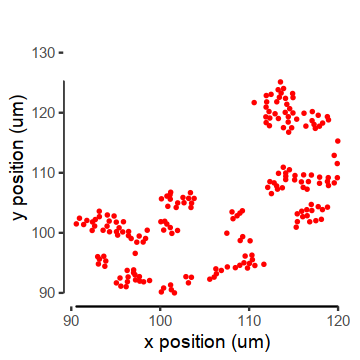

In [609]:
fig.size(3, 3)
data_if %>% 
    subset(Sample == 'RA195' & Image.number == 2) %>% 
    subset(center_x >= .9 & center_x <= 1.2 & center_y >= .9 & center_y <= 1.3) %>% 
    subset(cell_type == 'bldvessel' & is_ec == 1) %>% 
    ggplot(aes(100 * center_x, 100 * center_y)) + 
        geom_point(color = 'red', size = .5) + 
#         geom_point(data = . %>% subset(cell_type == 'bldvessel' & is_ec == 1), color = 'red', size = .5) + ## EC cells
#         theme_void() + 
        theme_tufte() + geom_rangeframe() + 
        scale_color_gradient2(
            mid = "grey", high = "blue", midpoint = -3, 
            guide = guide_colorbar(
                direction = "horizontal", title.position = "top",
                label.position = "bottom", label.hjust = 0.5, 
                label.vjust = 0.5,
                label.theme = element_blank()
            )
        ) + 
#         theme(strip.text = element_blank()) + 
        guides(area = FALSE, size = FALSE) + 
#         labs(color = "THY1:PRG4") + 
        labs(color = '') + 
        labs(x = 'x position (um)', y = 'y position (um)') + 
        scale_x_continuous(breaks = seq(0, 200, 10)) + 
        scale_y_continuous(breaks = seq(0, 200, 10), limits = c(90, 135)) + 
        theme(legend.position = c(0.3, .9)) + 
        NULL

ggsave("/data/srlab/ik936/NOTCH/tmp.pdf", device = 'pdf', height = 3, width = 3)

# Figure 2

## Ligand-Receptor dreamcatcher

In [159]:
library(circlize)

In [156]:
do_circos <- function(lr_df, significant_pairs, targets_bold) {
    genes_remove <- intersect(lr_df$ligand, lr_df$receptor) ## remove the rare genes that is both ligand and receptor
    significant_pairs %<>% 
        subset(!ligand %in% genes_remove & !receptor %in% genes_remove)    

    ## set up adjacency matrix
    mat <- lr_df %>% 
#         head(40) %>% 
        dplyr::select(ligand, receptor) %>% 
        dplyr::mutate(dummy = 1) %>% 
        tidyr::spread(ligand, dummy, fill = 0)         
    row.names(mat) <- mat$receptor
    mat$receptor <- NULL
    mat %<>% as.matrix()    

    ## space out the gene names that will be printed so they don't overlap
    ## this also minimizes crossing of significant lines
    ## first for receptors    
    target_receptors <- unique(significant_pairs$receptor)
    idx_rownames <- round(seq(quantile(1:nrow(mat), .35), 
                              quantile(1:nrow(mat), .65), 
                              length.out = length(target_receptors)))
    new_rownames <- rep("", nrow(mat))
    new_rownames[idx_rownames] <- target_receptors
    new_rownames[setdiff(1:nrow(mat), idx_rownames)] <- sample(setdiff(row.names(mat), target_receptors))

    
    ## then for ligands
    target_ligands <- rev(unique(significant_pairs$ligand))
    idx_colnames <- round(seq(quantile(1:ncol(mat), .35), 
                              quantile(1:ncol(mat), .65), 
                              length.out = length(target_ligands)))
    new_colnames <- rep("", ncol(mat))
    new_colnames[idx_colnames] <- target_ligands
    new_colnames[setdiff(1:ncol(mat), idx_colnames)] <- sample(setdiff(colnames(mat), target_ligands))

    mat <- mat[new_rownames, new_colnames]
#     mat <- mat[sample(row.names(mat)), sample(colnames(mat))]
    
    ## highlight the target genes
    target_genes <- c(target_ligands, target_receptors)
    for (i in 1:nrow(significant_pairs)) {    
        mat[significant_pairs[[i, "receptor"]], significant_pairs[[i, "ligand"]]] <- 2
    }
    
    ## set line colors
    col_mat <- matrix(NA, nrow(mat), ncol(mat))
    col_mat[mat == 1] <- "lightgrey"
    col_mat[mat == 2] <- "black"

    ## set sector colors
    grid.col <- c(rep(tableau_color_pal()(10)[4], ncol(mat)), rep(tableau_color_pal()(10)[2], nrow(mat)))
#     grid.col <- c(rep("red", ncol(mat)), rep("blue", nrow(mat)))
    names(grid.col) <- c(colnames(mat), row.names(mat))

    circos.clear()
#     circos.par(gap.degree = 0)
    circos.par(start.degree = 90, clock.wise = FALSE, gap.after = 0)

    chordDiagram(
        mat,
        grid.col = grid.col, 
        col = col_mat,
        small.gap = 0,
        big.gap = 10,    
        link.rank = rank(mat),    
        annotationTrack = "grid", 
        preAllocateTracks = list(track.height = max(strwidth(unlist(dimnames(mat)))))
    )

    circos.track(track.index = 1, panel.fun = function(x, y) {
        xlim = get.cell.meta.data("xlim")
        xplot = get.cell.meta.data("xplot")
        ylim = get.cell.meta.data("ylim")
        sector.name = get.cell.meta.data("sector.index")

        if (sector.name %in% targets_bold & sector.name %in% target_genes) {
            circos.text(mean(xlim), ylim[1], sector.name, facing = "clockwise",
                niceFacing = TRUE, adj = c(0, 0.5), col = "red")            
        } else if (sector.name %in% target_genes) {
            circos.text(mean(xlim), ylim[1], sector.name, facing = "clockwise",
                niceFacing = TRUE, adj = c(0, 0.5), col = "black")
        } else {
            circos.text(mean(xlim), ylim[1], "")
        }
    }, bg.border = NA)
    circos.clear()
    
}

In [165]:
fig.size(3, 4)

thresh <- 10 #-log10(.05)
thresh_pct <- 0.1
targets_both <- dplyr::inner_join(tissue$lr_df_st, joint$lr_df_st, by = c("ligand", "receptor"), suffix = c("_st", "_mm")) %>% 
    subset(ligand_expr_st > thresh & receptor_expr_st > thresh & ligand_expr_mm > thresh & receptor_expr_mm > thresh & 
           ligand_pct_st > thresh_pct & receptor_pct_st > thresh_pct & ligand_pct_mm > thresh_pct & receptor_pct_mm > thresh_pct) %>% 
    with(unique(c(ligand, receptor)))

with(joint, {
    significant_pairs <- lr_df_st %>% 
        subset(ligand_expr > thresh & receptor_expr > thresh & 
               ligand_pct > thresh_pct & receptor_pct > thresh_pct)
    
pdf('/data/srlab/ik936/NOTCH/paper/figure2/lr_organoid.pdf', width = 4, height = 3) 
do_circos(lr_df_st, significant_pairs, targets_both)
dev.off()    
    
})

png 
  2

In [166]:
fig.size(3, 3)
with(tissue, {
    significant_pairs <- lr_df_st %>% 
        subset(ligand_expr > thresh & receptor_expr > thresh & 
               ligand_pct > thresh_pct & receptor_pct > thresh_pct)

    pdf('/data/srlab/ik936/NOTCH/paper/figure2/lr_tissue.pdf', width = 4, height = 3, paper='special') 
    do_circos(lr_df_st, significant_pairs, targets_both)
    dev.off()    
        
})


png 
  2

## Pseudotime Projections

    Primary human SC
    mono-MM SC
    co-MM SC


In [270]:
## this also contains infered pseudotime and UMAP coordinates
meta_stability <- readRDS("/data/srlab/ik936/NOTCH/data/bulk_samples_w_umap.rds") %>% 
    dplyr::mutate(condition = ifelse(condition == "Day7/8", "Passage 1", condition)) %>% 
    dplyr::mutate(condition = ifelse(condition == "Day 14", "Passage 2", condition)) %>% 
    ## flip pseudotime so lining is on top
    dplyr::mutate(time = 1 - time) %>% 
    identity()

meta_mm_time <- readRDS("/data/srlab/ik936/NOTCH/data/cache_meta_mm.rds") %>% 
    ## flip pseudotime so lining is on top
    dplyr::mutate(time = 1 - time) %>% 
    identity()

In [362]:
quantile_info <- rbind(
    meta_mm_time %>% subset(condition2 == "MM1") %>% with(prop.table(table(cut(time, c(0, .1, .9, 1), include.lowest = TRUE)))) %>% 
        data.table() %>% dplyr::mutate(label = "MM1"),
    meta_mm_time %>% subset(condition2 == "MM2") %>% with(prop.table(table(cut(time, c(0, .1, .9, 1), include.lowest = TRUE)))) %>% 
        data.table() %>% dplyr::mutate(label = "MM2"),
    meta_mm_time %>% subset(condition2 %in% c("oa", "ra")) %>% with(prop.table(table(cut(time, c(0, .1, .9, 1), include.lowest = TRUE)))) %>% 
        data.table() %>% dplyr::mutate(label = "Tissue")
) %>% 
    dplyr::inner_join(data.table(V1 = c("[0,0.1]", "(0.1,0.9]", "(0.9,1]"), q = c(0, 50, 100)) )

plt_df <- meta_mm_time %>% 
    dplyr::mutate(label = ifelse(condition2 %in% c("oa", "ra"), "Tissue", condition2)) %>% 
    dplyr::inner_join(nice_names, by = c("label" = "given_name")) %>% 
    dplyr::mutate(nice_name = factor(nice_name, c("synovial tissue", "fibroblast organoid", "fibroblast + blood vessel\norganoid"))) %>% 
    dplyr::inner_join(quantile_info)

Joining, by = "label"


Warning message:
“Removed 22455 rows containing non-finite values (stat_density).”

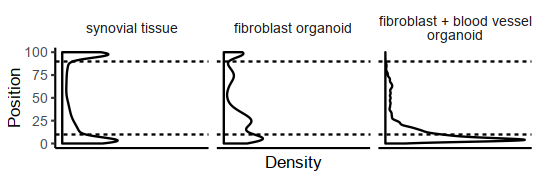

In [361]:
fig.size(1.5, 4.5)

(p1 <- plt_df %>% 
    ggplot(aes(100 * time)) + 
        geom_density() + 
        coord_flip() + 
        facet_wrap(~nice_name, nrow = 1) +
        theme_tufte(base_size = 10, base_family = 'Helvetica') + 
        geom_vline(xintercept = c(10, 90), linetype = 2) + 
        theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.line = element_line()) + 
        labs(x = "Position", y = "Density") + 
        NULL)

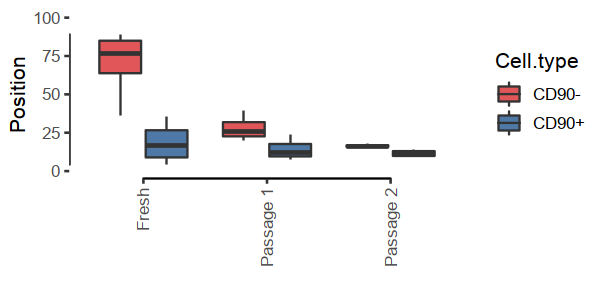

In [274]:
fig.size(2.5, 5)
(p2 <- meta_stability %>% 
    subset(!grepl("CD146", Cell.type)) %>% 
    dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
    dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", as.character(Cell.type))) %>% 
    ggplot(aes(condition, 100 * time, fill = Cell.type)) + 
        geom_boxplot(outlier.shape = NA) + 
        theme_tufte(base_size = 12) + geom_rangeframe(col = "black") + 
    theme(plot.title = element_text(size = 14, hjust = .5), 
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        scale_fill_manual(values = c(`CD90+` = palette_global[['sublining']], `CD90-` = palette_global[['lining']])) + 
        ylim(0, 100) + 
        labs(x = "", y = "Position")
)

## Bulk UMAP Projection

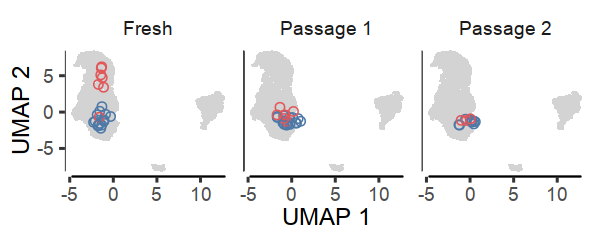

In [276]:
fig.size(2, 5)
(p3 <- umap_harmony %>% data.frame() %>% 
    cbind(meta_data) %>% 
    subset(X2 < 10) %>% 
    ggplot(aes(X1, X2)) + geom_point(shape = ".", color  = "lightgrey") + 
        theme_tufte(base_size = 14) + geom_rangeframe() + 
        geom_point(
            data = meta_stability %>% 
                dplyr::mutate(condition = factor(condition, c("Fresh", "Passage 1", "Passage 2"))) %>%
                dplyr::mutate(Cell.type = as.character(Cell.type)) %>% 
                dplyr::mutate(Cell.type = ifelse(grepl("CD34", Cell.type), "CD90+", Cell.type)) %>% 
                subset(!grepl("CD146", Cell.type)) %>% 
                identity(),
            size = 2, shape = 21,
            aes(color = Cell.type)
        ) + 
        facet_wrap(~condition) + 
        guides(color = FALSE) + 
        scale_color_manual(values = c(`CD90+` = palette_global[['sublining']], `CD90-` = palette_global[['lining']])) + 
        labs(x = "UMAP 1", y = 'UMAP 2') + 
        NULL
)

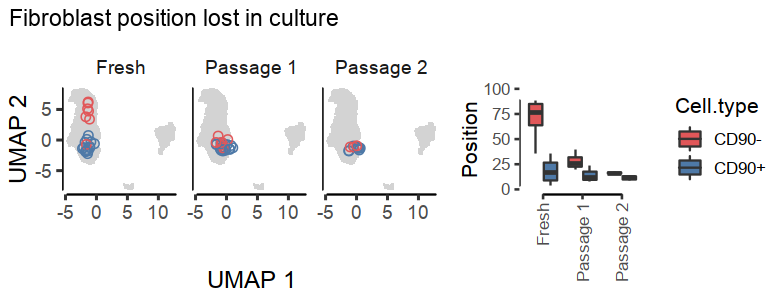

In [277]:
fig.size(2.5, 6.5)
p3 + p2 + 
plot_layout(nrow = 1, widths = c(3, 1)) +
    patchwork::plot_annotation(title = "Fibroblast position lost in culture")

## MM cell types UMAP

In [415]:
joint <- readRDS(file.path(cachedir, "analysis_sc_tissue_mm.rds"))

In [138]:
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM2"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM2" & joint$meta_data$cell_type != "blood"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)
100 * (joint$umap_projected[which(joint$meta_data$donor == "MM1"), 1] %>% cut(c(-20, -7, -2, 2, 10)) %>% table %>% prop.table)


.
 (-20,-7]   (-7,-2]    (-2,2]    (2,10] 
14.643545 13.921002  4.672447 66.763006 

.
  (-20,-7]    (-7,-2]     (-2,2]     (2,10] 
 0.1127396 16.2908681  5.4678692 78.1285231 

.
  (-20,-7]    (-7,-2]     (-2,2]     (2,10] 
 0.0000000  0.0000000  0.1383764 99.8616236 

In [418]:
fig.size(5, 5)
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))
    
    plt_df <- joint$umap_projected %>% 
        data.frame() %>% 
        cbind(joint$meta_data) %>% 
        dplyr::mutate(label = ifelse(source == 'culture', donor, disease)) %>% 
        dplyr::mutate(label = ifelse(grepl("^MM", donor), donor, "synovial tissue")) %>% 
        dplyr::arrange(source == "culture") %>% ## put MM cells on top
        dplyr::mutate(label = ifelse(label == "MM1", "fibroblast", label)) %>% 
        dplyr::mutate(label = ifelse(label == "MM2", "fibroblast + blood vessel", label)) 
    
    plt_df %>% 
        subset(source == "culture") %>% 
        ggplot(aes(X1, X2)) +
            guides(color = FALSE) + 
            geom_point_rast(width = 5, height = 5, dpi = 300,
                color = "lightgrey", 
                data = plt_df %>% subset(source == 'primary') %>% dplyr::select(-label), 
                shape = '.', alpha = .5
            ) + 
            geom_point_rast(
                data = . %>% subset(source == "culture"), aes(color = label),
                dpi = 300, width = 6, height = 4, size = .5
            ) + 
            labs(x = "UMAP 1", y = "UMAP 2") + 
#             labs(x = "DDRTree 2", y = "DDRTree 1", title = "Fibroblast + Blood Vessel Organoid") + 
            scale_color_manual(values = c(`synovial tissue` = "grey", MM1 = '#F28E2B', MM2 = '#F28E2B', 
                                          `fibroblast` = '#F28E2B', `fibroblast + blood vessel` = '#F28E2B')) + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + #geom_rangeframe(color = "black") + 
            theme(panel.background = element_rect(), strip.text = element_blank()) + 
            scale_y_continuous(position = "right") + 
            facet_wrap(~label, ncol = 1) + 
            NULL
    
    ggsave('/data/srlab/ik936/NOTCH/paper/figure2/umap_mm.pdf', device = "pdf", 
           dpi = 300, width = 4, height = 5, useDingbats = FALSE)    
})



## Organoid DDR projections

In [477]:
fig.size(2.5, 10)
with(joint, {
    idx_mm <- which(meta_data$source == "culture")
    idx_pr <- which(meta_data$source == "primary" & meta_data$cell_type %in% c("lining", "sublining"))
    
    plt_df <- ddr_Z %>% data.frame() %>% 
        cbind(meta_data[c(idx_pr, idx_mm), ]) %>% 
        dplyr::mutate(label = ifelse(source == 'culture', donor, disease)) %>% 
        subset(!cell_type %in% c("blood")) %>%     
        dplyr::mutate(label = ifelse(grepl("^MM", donor), donor, "synovial tissue")) %>% 
        dplyr::arrange(source == "culture") %>% ## put MM cells on top
        dplyr::mutate(label = ifelse(label == "MM1", "fibroblast", label)) %>% 
        dplyr::mutate(label = ifelse(label == "MM2", "fibroblast + blood vessel", label)) 
    
    plt_df %>% 
        subset(source == "culture") %>% 
        ggplot(aes(-X2, X1)) +
            guides(color = FALSE) + 
            geom_point_rast(dpi = 300, width = 2, height = 2,
                color = "lightgrey", 
                data = plt_df %>% subset(source == 'primary') %>% dplyr::select(-label), 
                shape = '.', alpha = .5
            ) + 
            geom_point(data = data.frame(t(tissue$ddrtree_res$Y)), color = 'black') + 
            geom_point_rast(
                data = . %>% subset(source == "culture" & time < 80), color = '#F28E2B',
                dpi = 300, width = 2, height = 2, shape = '.'
            ) + 
            geom_point_rast(
                data = . %>% subset(source == "culture" & time > 80), color = 'red',
                dpi = 300, width = 2, height = 2, shape = '.'
            ) + 
            labs(x = "DDRTree 2", y = "DDRTree 1") + 
            theme_tufte(base_size = 14, base_family = "Helvetica") + #geom_rangeframe(color = "black") + 
            theme(panel.background = element_rect(), strip.text = element_blank()) + 
            facet_wrap(~label, ncol = 2) + 
            NULL

    ggsave('/data/srlab/ik936/NOTCH/paper/figure2/ddrtree_mm.pdf', device = "pdf", 
           dpi = 300, width = 10, height = 2.5, useDingbats = FALSE)    

})



# Figure 3

## NOTCH3 vs JAG1

In [320]:
## First, in MM data
with(joint, {
    plt_df <<- exprs_norm[c("JAG1", "NOTCH3"), ] %>% 
        as.matrix() %>% t() %>% 
        data.frame() %>%
        cbind(meta_data) %>% 
        subset(!cell_type %in% c("endothelial", "leukocytes")) %>% ## keeps fibroblasts and pericytes
        identity()
})


cor_res <- data.table(plt_df)[, broom::tidy(cor.test(~NOTCH3 + JAG1, method = "pearson")), by = .(source)] %>% 
    identity()    


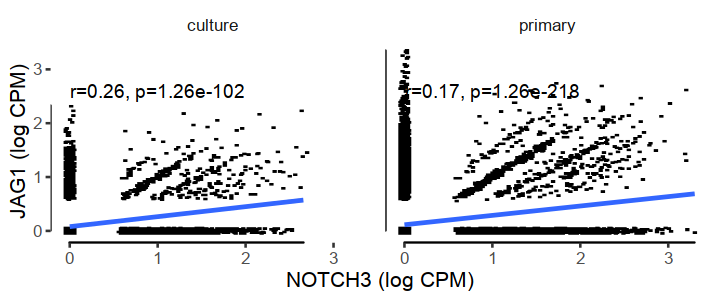

In [321]:
fig.size(2.5, 6)

plt_df %>% 
    ggplot(aes(NOTCH3, JAG1)) + 
        geom_point_rast(width = 1, height = 1, dpi = 300,
            shape = ".", position = position_jitter(width = .05, height = .05)
        ) + 
        theme_tufte(base_size = 12) + 
        geom_rangeframe() + 
        geom_text(
            data = cor_res, size = 4, 
            aes(x = 1, y = 2.6, label = sprintf("r=%.2f, p=%.2e", estimate, p.value))
        ) + 
        facet_wrap(~source) + 
        geom_smooth(method = "lm") + 
        labs(y = "JAG1 (log CPM)", x = "NOTCH3 (log CPM)") + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/jag_notch_corr.pdf', device = "pdf", 
       dpi = 300, width = 6, height = 2.5, useDingbats = FALSE)

## NOTCH MFI RAvOA

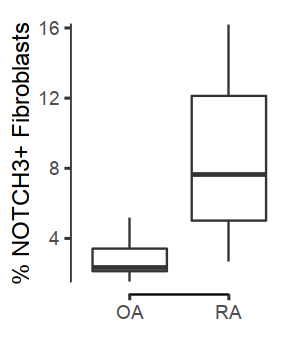

In [388]:
fig.size(3, 2.5)
str <- "OA	RA
2.32	4.53
1.54	14
3.42	2.68
5.18	3.28
2.13	16.2
	8.91
	8.76
	13.2
	6.48
	6.51"
plt_df <- fread(text = str) %>% 
    tidyr::gather(key, val) %>% 
    subset(!is.na(val)) 

plt_df %>% 
    ggplot(aes(key, val)) + 
        geom_boxplot() + 
#         geom_point(shape = 21, position = position_jitter(width = .25, height = 0), size = 2) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = "% NOTCH3+ Fibroblasts", x = "") + 
#         geom_text(x = .5, y = 15, label = sprintf("p=%.3f", broom::tidy(t.test(val ~ key, plt_df))$p.value), 
#                   hjust = 0, size = 6) + 
    #     theme(panel.background = element_rect()) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch3_mfi_ra_oa.pdf', device = "pdf", 
       dpi = 300, width = 2.5, height = 3, useDingbats = FALSE)

## NOTCH3 MFI by subsets

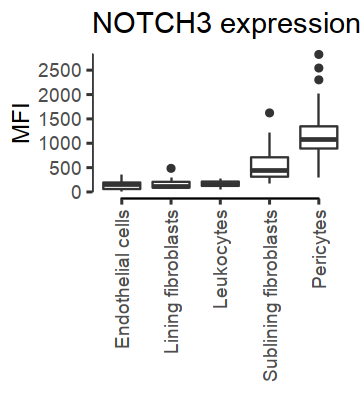

In [385]:
data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 3/Notch3 expression by flow in fibroblasts subsets.txt")

fig.size(3.5, 3)
data_df %<>% 
    tidyr::gather(type, value) %>% 
    subset(!is.na(value)) %>% 
    subset(value > 0) 

data_df %>% 
    ggplot(aes(reorder(type, value), value + 1)) + 
        geom_boxplot() + 
#         geom_point(shape = 21, position = position_jitter(width = .1, height = 0), size = 1) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        labs(y = 'MFI', x = '', fill = '', color = '', title = 'NOTCH3 expression') + 
        scale_y_continuous(breaks = seq(0, 3000, 500)) + 
#         scale_y_log10() + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/notch3_mfi.pdf', device = "pdf", 
       dpi = 300, width = 3, height = 3.5, useDingbats = FALSE)

In [387]:
table(data_df$type)


    Endothelial cells            Leukocytes    Lining fibroblasts 
                   15                    19                    20 
            Pericytes Sublining fibroblasts 
                   18                    40 

In [354]:
type_levels <- data.table(data_df)[, (median(value)), by = type][order(V1), type]

data_df %>% 
    dplyr::mutate(type = factor(type, type_levels)) %>% 
    with(cor.test(~ value + as.integer(type), method = 'spearman') %>% broom::tidy())
#     with(t.test(value ~ type))

Warning message in cor.test.default(x = c(267, 155, 255, 221, 175, 233, 51.6, 92.4, :
“Cannot compute exact p-value with ties”

estimate,statistic,p.value,method,alternative
0.8098348,44524.53,3.106005e-27,Spearman's rank correlation rho,two.sided


## Ligand screen

In [379]:
ligands_df <- data.table(
    ligand = c('TGFB', 'BMP7', 'Activin A', 'Wnt3a', 'Wnt5a', 'JAG1', 'DLL4', 'EGF', 'PDGF-BB', 'IFNG', 'TNF'), 
    type = rep(c('Morphogen', 'Growth\nFactor', 'Cytokine'), c(7, 2, 2))
)

Joining, by = "ligand"


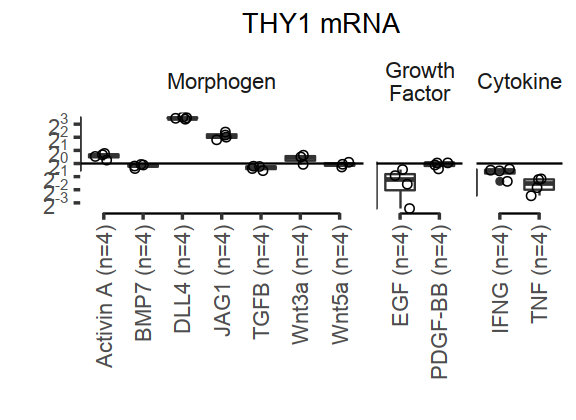

In [384]:
fig.size(3.5, 4.8)
plt_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 3/Fig3D THY1 qPCR.txt") %>% 
    tidyr::gather(ligand, value) %>% 
    subset(!is.na(value)) %>% 
    dplyr::inner_join(ligands_df) %>% 
    dplyr::mutate(ligand = factor(ligand, ligands_df$ligand)) %>% 
    dplyr::mutate(type = factor(type, c('Morphogen', 'Growth\nFactor', 'Cytokine'))) %>% 
    identity()

plt_df %>% 
    ggplot(aes(sprintf('%s (n=4)', ligand), value)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .25, height = 0), size = 2) + 
        facet_grid(.~type, scales = "free_x", space = "free_x") + 
        theme_tufte(base_size = 16, base_family = "Helvetica") + 
        geom_rangeframe() + 
        labs(y = '', x = '', title = 'THY1 mRNA') + 
        theme(plot.title = element_text(hjust = .5, size = 16)) + 
        geom_hline(yintercept = 1) + 
         scale_y_continuous(
             trans = 'log2',
             breaks = 2 ^ seq(-5, 5, 1), 
             labels = scales::trans_format("log2", scales::math_format(2^.x))
         ) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/ligand_screen.pdf', device = "pdf", 
       dpi = 300, width = 4.8, height = 3.5, useDingbats = FALSE)

In [523]:
data.table(plt_df)[, broom::tidy(t.test(value, mu=0)), by = ligand] %>% 
    dplyr::mutate(fdr = p.adjust(p.value)) %>% 
    subset(fdr < .05 & estimate > 2)

,ligand,estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative,fdr
6,DLL4,11.048995,42.90044,2.787639e-05,3,10.229357,11.868633,One Sample t-test,two.sided,0.0002508875
7,JAG1,4.327108,11.50824,1.408521e-03,3,3.130505,5.523711,One Sample t-test,two.sided,0.0056340847


## JAG1 MFI

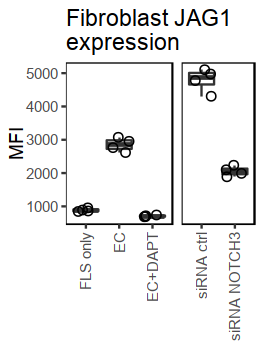

In [327]:
# data_df <- '/data/srlab/ik936/NOTCH/data/'
str <- '170908 coculture_DAPT_001_010.fcs   742
170908 coculture_DAPT_002_011.fcs   718
170908 coculture_DAPT_003_012.fcs   689
170908 coculture_DAPT_009.fcs   692
170908 coculture_coculture_001_006.fcs  2954
170908 coculture_coculture_002_007.fcs  3075
170908 coculture_coculture_003_008.fcs  2617
170908 coculture_coculture_005.fcs  2764
170908 coculture_fls_001_002.fcs    847
170908 coculture_fls_001.fcs    955
170908 coculture_fls_002_003.fcs    862
170908 coculture_fls_003_004.fcs    891
170908 coculture_siCTRL_001_022.fcs 4975
170908 coculture_siCTRL_002_023.fcs 4779
170908 coculture_siCTRL_003_024.fcs 5104
170908 coculture_siCTRL_021.fcs 4307
170908 coculture_siNOTCH3_2_001_018.fcs 1991
170908 coculture_siNOTCH3_2_002_019.fcs 2235
170908 coculture_siNOTCH3_2_003_020.fcs 2100
170908 coculture_siNOTCH3_2_017.fcs 1889'

fig.size(3, 2.2)

plt_df <- fread(text = str) %>% 
    dplyr::select(-V1) %>% 
    dplyr::mutate(V2 = gsub('(_\\d+)+.fcs', '', V2)) %>%
    dplyr::mutate(
        type = dplyr::case_when(
            V2 == 'coculture_DAPT' ~ 'EC+DAPT', 
            V2 == 'coculture_coculture' ~ 'EC', 
            V2 == 'coculture_fls' ~ 'FLS only', 
            V2 == 'coculture_siCTRL' ~ 'siRNA ctrl', 
            V2 == 'coculture_siNOTCH3' ~ 'siRNA NOTCH3')
    ) %>% 
    dplyr::mutate(
        type2 = dplyr::case_when(
            type %in% c('siRNA ctrl', 'siRNA NOTCH3') ~ 2,
            TRUE ~ 1    
        )
    ) %>% 
    dplyr::mutate(type = factor(type, c('FLS only', 'EC', 'EC+DAPT','siRNA ctrl', 'siRNA NOTCH3'))) 

plt_df %>% 
    ggplot(aes(type, V3)) + 
        geom_boxplot() + 
        geom_point(shape = 21, position = position_jitter(width = .3, height = 0), size = 2) + 

        theme_tufte() + 
        labs(x = '', y = 'MFI', title = 'Fibroblast JAG1\nexpression') + 
#         theme(plot.title = element_text(hjust = .5, size = 16)) + 
        theme(
            panel.background = element_rect(),
            axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5),
            strip.text = element_blank()        
        ) + 
        facet_grid(.~type2, scales = "free_x", space = "free_x") 

ggsave('/data/srlab/ik936/NOTCH/paper/figure3/jag1_mfi.pdf', device = "pdf", 
       dpi = 300, width = 2.2, height = 3, useDingbats = FALSE)

In [336]:
t.test(V3 ~ type, subset(plt_df, type %in% c('siRNA ctrl', 'siRNA NOTCH3')))



	Welch Two Sample t-test

data:  V3 by type
t = 14.423, df = 4.0483, p-value = 0.0001243
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 2212.999 3262.001
sample estimates:
  mean in group siRNA ctrl mean in group siRNA NOTCH3 
                   4791.25                    2053.75 


# Figure 4


## disease activity

In [169]:
datadir <- "/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 4/"

In [403]:
do_lineplot <- function(fname, xlab, ylab, pal, type, pval_pos, no_bottom = FALSE) {
    plt_df <- fread(file.path(datadir, fname)) 
    colnames(plt_df) <- c('V1', tail(colnames(plt_df), -1))
    plt_df <- plt_df %>% 
        data.frame() %>% 
        tidyr::gather(sample, value, -V1) %>% 
        dplyr::mutate(value = gsub("\\*", "", value), 
                      value = as.numeric(value)) %>% 
        subset(!is.na(value)) %>% 
        dplyr::rename(timepoint = V1) %>% 
        dplyr::mutate(phenotype = ifelse(grepl("Wild|Isotype|WT", sample, ignore.case = TRUE), "ctrl", "n3ko|N3KO")) 
    pval <- broom::tidy(lm(value ~ 1 + phenotype + timepoint, plt_df))[2, 'p.value']

    if (type == "smooth") {        
        plt <- plt_df %>% 
            ggplot(aes(timepoint, value, color = phenotype, fill = phenotype)) + 
                geom_smooth() 
    } else {
        print(table(plt_df$phenotype))
        plt <- data.table(plt_df)[, .(mu = mean(value), sig = sd(value)), by = .(phenotype, timepoint)] %>%
            ggplot(aes(timepoint, mu, color = phenotype, fill = phenotype)) + 
                geom_point() + 
                geom_line() + 
                geom_errorbar(aes(ymin = mu - sig, ymax = mu + sig), width = .5) 
    }
    plt <- plt + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + 
        scale_color_manual(values = pal) + 
        scale_fill_manual(values = pal) + 
        scale_x_continuous(breaks = seq(0, 20, 1)) + 
        guides(color = FALSE, fill = FALSE) + 
        labs(subtitle = sprintf("p=%.2e", pval))
    
    if (no_bottom) {
        plt + theme(axis.ticks = element_line(size = .75), 
                  axis.line.y.left = element_line(size = .75), 
                  axis.line.x.bottom = element_line(size = .75), 
                  plot.title = element_text(hjust = .5),
                  axis.title.y = element_text(size = 20), 
                  axis.text.x = element_blank(), axis.ticks.x = element_blank(),
                  axis.title.x = element_blank(), axis.line.x = element_blank()) 
        
    } else {
        plt + theme(axis.ticks = element_line(size = .75), 
              axis.line.y.left = element_line(size = .75), 
              axis.line.x.bottom = element_line(size = .75), 
              plot.title = element_text(hjust = .5), 
              axis.title.y = element_text(size = 20), 
              axis.title.x = element_text(size = 20))
               
    }

    
        

}


     ctrl n3ko|N3KO 
      149       171 

     ctrl n3ko|N3KO 
      149       171 

     ctrl n3ko|N3KO 
      280       280 

     ctrl n3ko|N3KO 
      280       280 


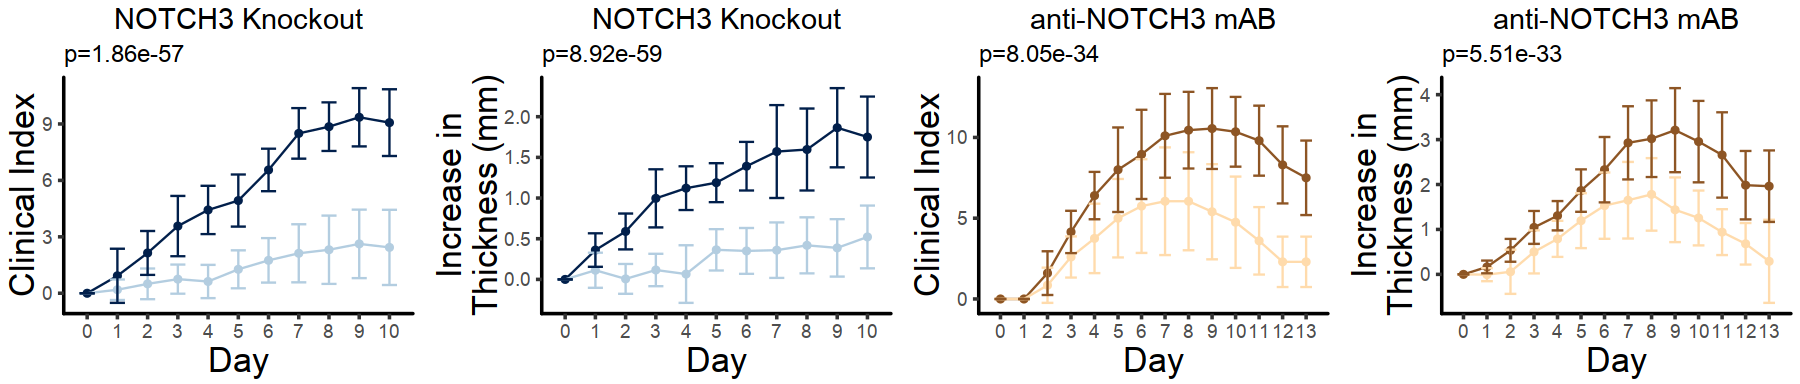

In [408]:
options(repr.plot.height = 3.2, repr.plot.width = 15)
# type <- "smooth" 
type <- "line"


palette_histology <- c('#011f4b', '#b3cde0', '#8d5524', '#ffdbac')


do_lineplot("n3KO clinical index.txt", "Day", 
# do_lineplot("N3KO vs WT arthritis clinical index.txt", "Day", 
            "Clinical Index", palette_histology[1:2], type, 
            c(2, 9), no_bottom = FALSE) +
    labs(title = "NOTCH3 Knockout", y = 'Clinical Index', x = 'Day') + 
do_lineplot("n3KO joint thickness.txt", "Day", 
# do_lineplot("N3KO vs WT arthritis joint thickness.txt", "Day", 
            "Increase in Joint\nThickness (mm)", palette_histology[1:2], type, 
            c(2, 2)) +
    labs(title = "NOTCH3 Knockout", y = 'Increase in\nThickness (mm)', x = 'Day') + 
do_lineplot("anti-N3 mAB vs isotype arthritis clinical index.txt", "Day", 
            "Clinical Index", palette_histology[3:4], type, 
            c(2, 10.5), no_bottom = FALSE) +
    labs(title = "anti-NOTCH3 mAB", y = 'Clinical Index', x = 'Day') + 
do_lineplot("anti-N3 mAB vs isotype arthritis joint thickness.txt", "Day", 
            "Increase in Joint\nThickness (mm)", palette_histology[3:4], type, 
            c(2, 3.5)) + 
    labs(title = "anti-NOTCH3 mAB", y = 'Increase in\nThickness (mm)', x = 'Day') + 
patchwork::plot_layout(byrow = FALSE, nrow = 1)

ggsave('/data/srlab/ik936/NOTCH/paper/figure4/disease_activity.pdf', device = "pdf", 
       dpi = 300, width = 15, height = 3.2, useDingbats = FALSE)

In [358]:
fig.size(3, 5)
data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/cumulative histological score in arthritis mice.txt")
data_df %<>% data.frame() %>% 
    tidyr::gather(type, value, -V1) %>% 
    dplyr::mutate(type = gsub('\\..*', '', type)) %>% 
    identity()

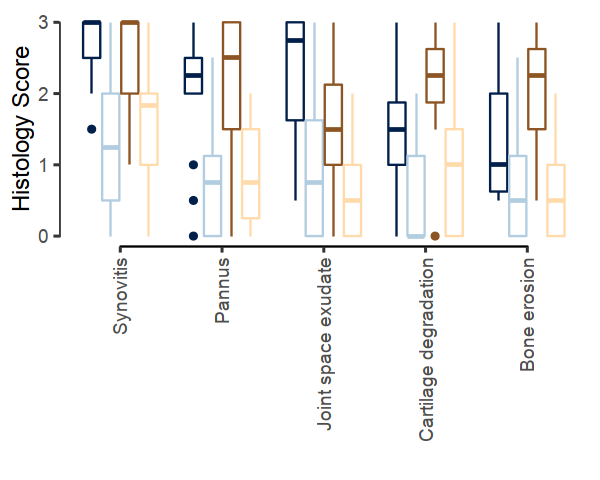

In [359]:
fig.size(4, 5)
data_df <- data_df %>% 
    subset(!is.na(value)) %>% 
    dplyr::mutate(type = factor(type, c('WT', 'Notch3', 'Isotype', 'anti'))) %>% 
    dplyr::mutate(V1 = factor(V1, c('Synovitis', 'Pannus', 'Joint space exudate', 'Cartilage degradation', 'Bone erosion'))) 

data_df %>% 
    ggplot(aes(V1, value)) + 
        geom_boxplot(aes(color = type)) +         
        scale_color_manual(values = palette_histology) + 
        scale_fill_manual(values = palette_histology) + 
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        labs(y = 'Histology Score', x = '', fill = '', color = '') + 
        guides(color = FALSE) + 
        NULL

ggsave('/data/srlab/ik936/NOTCH/paper/figure4/histology.pdf', device = "pdf", 
       dpi = 300, width = 5, height = 4, useDingbats = FALSE)



In [361]:
table(data_df$type, data_df$V1) 

         
          Synovitis Pannus Joint space exudate Cartilage degradation
  WT             14     14                  14                    14
  Notch3         16     16                  16                    16
  Isotype        20     20                  20                    20
  anti           20     20                  20                    20
         
          Bone erosion
  WT                14
  Notch3            16
  Isotype           20
  anti              20

In [253]:
data.table(data_df)[
    type %in% c('WT', 'Notch3'), 
    data.table(broom::tidy(lm(value ~ type)))[term != '(Intercept)'], 
    by = V1]

data.table(data_df)[
    type %in% c('Isotype', 'anti'), 
    data.table(broom::tidy(lm(value ~ type)))[term != '(Intercept)'], 
    by = V1]


V1,term,estimate,std.error,statistic,p.value
Synovitis,typeNotch3,-1.2723214,0.2885983,-4.408624,0.0001393231
Pannus,typeNotch3,-1.1562500,0.3270299,-3.535610,0.0014368550
Joint space exudate,typeNotch3,-1.2901786,0.3596205,-3.587611,0.0012543122
Cartilage degradation,typeNotch3,-0.8616071,0.2919820,-2.950891,0.0063407174
Bone erosion,typeNotch3,-0.5714286,0.2999009,-1.905391,0.0670454570


V1,term,estimate,std.error,statistic,p.value
Synovitis,typeanti,-0.925000,0.2356945,-3.924572,3.529838e-04
Pannus,typeanti,-1.283335,0.2790834,-4.598393,4.615181e-05
Joint space exudate,typeanti,-0.975000,0.2443439,-3.990277,2.906524e-04
Cartilage degradation,typeanti,-1.250000,0.2474874,-5.050763,1.132849e-05
Bone erosion,typeanti,-1.525000,0.2250000,-6.777778,4.922127e-08


## Composite erosion score

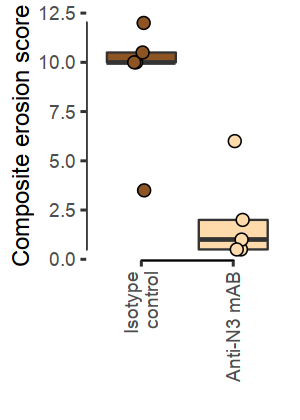

In [355]:
# palette_histology <- c('#011f4b', '#b3cde0', '#8d5524', '#ffdbac')
fig.size(3.5, 2.5)
data_df <- fread("/data/srlab/ik936/NOTCH/data/Manuscript_data/Figure 4/µCT score.txt") %>% t %>% data.frame() %>% 
    tibble::rownames_to_column("id") %>%
    dplyr::mutate(type = ifelse(grepl('Isotype', id), 'Isotype\ncontrol', 'Anti-N3 mAB')) %>% 
    dplyr::mutate(type = factor(type, c('Isotype\ncontrol', 'Anti-N3 mAB'))) %>% 
    subset(!is.na(`.`)) 

data_df %>% 
    ggplot(aes(type, `.`)) + 
        geom_boxplot(aes(fill = type)) +
        geom_point(aes(fill = type), shape = 21, 
                   position = position_jitterdodge(jitter.width = .5, jitter.height = 0), 
                   size = 3) + 
#         geom_boxplot(aes(color = type)) +
        theme_tufte(base_size = 14, base_family = "Helvetica") + geom_rangeframe() + 
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5)) + 
        labs(y = 'Composite erosion score', x = '', fill = '', color = '') + 
        guides(color = FALSE, fill = FALSE) + 
        scale_color_manual(values = palette_histology[3:4]) + 
        scale_fill_manual(values = palette_histology[3:4]) + 
        NULL


ggsave('/data/srlab/ik936/NOTCH/paper/figure4/erosion.pdf', device = "pdf", 
       dpi = 300, width = 2.5, height = 3.5, useDingbats = FALSE)


In [357]:
table(data_df$type)


Isotype\ncontrol      Anti-N3 mAB 
               5                5 

In [235]:
t.test(`.` ~ type, data_df)


	Welch Two Sample t-test

data:  . by type
t = 4, df = 7.1866, p-value = 0.004917
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  2.965981 11.434019
sample estimates:
mean in group Isotype\ncontrol      mean in group Anti-N3 mAB 
                           9.2                            2.0 


# Tables

## Markers

In [303]:
my_list <- list(
    tissue$markers$auc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, AUC, -symbol),
    tissue$markers$fdr %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, FDR, -symbol),
    tissue$markers$lfc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, logFoldChange, -symbol),
    tissue$markers$means %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, averageExpression, -symbol),
    tissue$markers$pct_in %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, percentNonZero, -symbol)
)


dge_tissue <- Reduce(dplyr::inner_join, my_list) %>% dplyr::mutate(dataset = 'synovialTissue')


my_list <- list(
    joint$markers_mm2$auc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, AUC, -symbol),
    joint$markers_mm2$fdr %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, FDR, -symbol),
    joint$markers_mm2$lfc %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, logFoldChange, -symbol),
    joint$markers_mm2$means %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, averageExpression, -symbol),
    joint$markers_mm2$pct_in %>% data.frame() %>% tibble::rownames_to_column('symbol') %>% 
        tidyr::gather(cell_type, percentNonZero, -symbol)
)


dge_organoid <- Reduce(dplyr::inner_join, my_list) %>% dplyr::mutate(dataset = 'coculturedOrganoid')


Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")
Joining, by = c("symbol", "cell_type")


In [306]:
rbind(dge_tissue, dge_organoid) %>% 
    dplyr::select(dataset, cell_type, symbol, AUC, FDR, logFoldChange, averageExpression, percentNonZero) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_markers.csv', sep = ',')    

## IF

In [ ]:
data_if %>% dplyr::select(Sample, Image.number, center_x, center_y, THY1 = CD90,
                          PRG4 = Lubricin, VWF, MCAM = CD146, region = cell_type, 
                          disease, ncells_image, thy1_prg4_ratio = ratio, is_ec,
                          dist_EC = dist_EC2) %>% 
    subset(ncells_image > 1000) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_if.csv', sep = ',')



## Ligand Receptors

In [281]:
x <- tissue$lr_df_st
colnames(x) <- c('ligand', 'receptor', 'ligand_fdr', 'ligand_percentNonZero', 'receptor_fdr', 'receptor_percentNonZero')
y <- joint$lr_df_st
colnames(y) <- c('ligand', 'receptor', 'ligand_fdr', 'ligand_percentNonZero', 'receptor_fdr', 'receptor_percentNonZero')


In [285]:
dplyr::full_join(x, y, by = c('ligand', 'receptor'), suffix = c('_synovialTissue', 'organoid')) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_lr.csv', sep = ',')

## Stimulation DGE

In [308]:
with(bulk, {
    dplyr::full_join(
        dge_jag1 %>% dplyr::select(-rank),
        dge_dll4 %>% dplyr::select(-rank), 
        by = c('symbol'), 
        suffix = c('_JAG1', 'DLL4')
    ) %>% 
    fwrite('/data/srlab/ik936/NOTCH/paper/table_stim.csv', sep = ',')        
})
